In [ ]:
!pip install botorch
!pip install rdkit
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.3/530.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 13.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 29.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import rdmolfiles, rdmolops, AllChem, Draw, rdDepictor, Descriptors
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Fingerprints import FingerprintMols

from IPython.display import SVG
from IPython.display import HTML
from IPython.display import display

import torch
from botorch.models import SingleTaskGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from botorch.models.multitask import MultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.optim import Adam
from collections import defaultdict
from tqdm import tqdm

#**Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Data/Binary Polymer Solution Cloud Point Database.csv')
df['Polymer Mols'] = df['Polymer SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df['Solvent Mols'] = df['Solvent SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df = df.dropna(0)

<ipython-input-5-b1f5684ff214>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna(0)


In [ ]:
df

,Polymer,Polymer CAS,Polymer SMILES,Solvent,Solvent CAS,Solvent SMILES,Mw(Da),PDI,ϕ,w,P(Mpa),CP(°C),1-Phase,Ref.,Polymer Mols,Solvent Mols
0,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],27200,1.03,0.12780,0.1202,4.73,-3.97,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7fd26a0b3ba0>,<rdkit.Chem.rdchem.Mol object at 0x7fd269fcb9e0>
1,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],27200,1.03,0.17425,0.1644,4.44,-4.08,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7fd26a05d660>,<rdkit.Chem.rdchem.Mol object at 0x7fd269fcbac0>
2,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],27200,1.03,0.19746,0.1866,0.48,-3.87,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7fd26a05d2e0>,<rdkit.Chem.rdchem.Mol object at 0x7fd269fcba50>
3,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,propionitrile,107-12-0,CCC#N,26700,1.05,0.09173,0.1100,2.28,172.28,negative,doi.org/10.1021/ma9517308,<rdkit.Chem.rdchem.Mol object at 0x7fd26a05d6d0>,<rdkit.Chem.rdchem.Mol object at 0x7fd269fcbb30>
4,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],85200,1.02,0.11958,0.1124,0.25,14.99,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7fd26a05d740>,<rdkit.Chem.rdchem.Mol object at 0x7fd269fcbba0>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6519,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.44220,0.5056,0.10,63.14,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7fd269fcb6d0>,<rdkit.Chem.rdchem.Mol object at 0x7fd269f07cf0>
6520,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.09225,0.1159,0.10,71.08,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7fd269fcb740>,<rdkit.Chem.rdchem.Mol object at 0x7fd269f07d60>
6521,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.11156,0.1394,0.10,72.63,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7fd269fcb7b0>,<rdkit.Chem.rdchem.Mol object at 0x7fd269f07dd0>
6522,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.34850,0.4083,0.10,73.50,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7fd269fcb820>,<rdkit.Chem.rdchem.Mol object at 0x7fd269f07e40>


In [ ]:
#Remove rows with polyetyrene-d8 (includes deuterium)
index_d_droped = df[(df["Polymer"] == "polystyrene-d8") | (df["Solvent"] == "nitroethane-d5")].index
df_new = df.drop(index_d_droped)
df_new

,Polymer,Polymer CAS,Polymer SMILES,Solvent,Solvent CAS,Solvent SMILES,Mw(Da),PDI,ϕ,w,P(Mpa),CP(°C),1-Phase,Ref.,Polymer Mols,Solvent Mols
395,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclohexane,108-87-2,CC1CCCCC1,17500,1.06,0.11406,0.15000,82.81,21.34,positive,doi.org/10.1002/macp.1994.021950233,<rdkit.Chem.rdchem.Mol object at 0x7fd26a021510>,<rdkit.Chem.rdchem.Mol object at 0x7fd269f5a970>
396,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclohexane,108-87-2,CC1CCCCC1,17500,1.06,0.18196,0.23366,80.00,21.18,positive,doi.org/10.1002/macp.1994.021950233,<rdkit.Chem.rdchem.Mol object at 0x7fd26a021580>,<rdkit.Chem.rdchem.Mol object at 0x7fd269f5a9e0>
397,polystyrene,9003-53-6,*C(C*)c1ccccc1,cyclohexanol,108-93-0,OC1CCCCC1,78800,1.12,0.00632,0.00700,0.10,73.99,positive,doi.org/10.1021/je0504865,<rdkit.Chem.rdchem.Mol object at 0x7fd26a0215f0>,<rdkit.Chem.rdchem.Mol object at 0x7fd269f5aa50>
398,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclopentane,96-37-7,CC1CCCC1,22100,1.03,0.11401,0.15300,1.02,27.42,positive,doi.org/10.1021/ma00107a011,<rdkit.Chem.rdchem.Mol object at 0x7fd26a021660>,<rdkit.Chem.rdchem.Mol object at 0x7fd269f5aac0>
399,polystyrene,9003-53-6,*C(C*)c1ccccc1,nitroethane,79-24-3,CC[N+](=O)[O-],13500,1.06,0.17990,0.17990,4.35,6.08,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7fd26a0216d0>,<rdkit.Chem.rdchem.Mol object at 0x7fd269f5ab30>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6519,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.44220,0.50560,0.10,63.14,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7fd269fcb6d0>,<rdkit.Chem.rdchem.Mol object at 0x7fd269f07cf0>
6520,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.09225,0.11590,0.10,71.08,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7fd269fcb740>,<rdkit.Chem.rdchem.Mol object at 0x7fd269f07d60>
6521,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.11156,0.13940,0.10,72.63,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7fd269fcb7b0>,<rdkit.Chem.rdchem.Mol object at 0x7fd269f07dd0>
6522,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.34850,0.40830,0.10,73.50,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7fd269fcb820>,<rdkit.Chem.rdchem.Mol object at 0x7fd269f07e40>


# **Descriptor Calculation**

In [ ]:
class Morgan_fingerprint(): #From Chen

    def __init__(self,mols):
        self.mols = mols
        self.bitExamples = {}
        self.keepMols = {}
        return

    def calculate(self,radius=2,bits=1024,vector_type="count",unhash=False):
        if vector_type not in ["count","bit"]:
            return
        elif vector_type=="bit":
            unhash=False
            fp_all = defaultdict()

        mols = self.mols
        self.bits = bits
        self.radius = radius
        self.bitI_morgan =  {}
        morgan_count = defaultdict(lambda:[0]*len(mols))
        for idx,mol in enumerate(tqdm(mols)):
            self.bitI_morgan[idx] = {}
            if unhash==True:
                fp_morgan = AllChem.GetMorganFingerprint(mol, radius, bitInfo=self.bitI_morgan[idx])
            else:
                fp_morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius,
                                                                  bitInfo=self.bitI_morgan[idx],nBits=bits)
                if vector_type=="bit":
                    arr = np.zeros((1,))
                    DataStructs.ConvertToNumpyArray(fp_morgan, arr)
                    fp_all[idx]= arr
            for key in list(self.bitI_morgan[idx].keys()):
                morgan_count["{}".format(key)][idx]=len(self.bitI_morgan[idx][key])
                #generate bit examples for visualization
                self.bitExamples[key] = idx
                self.keepMols[idx]=mol

        if vector_type=="bit": return pd.DataFrame.from_dict(fp_all).T #Bit type
        return pd.DataFrame.from_dict(morgan_count)

    def visualize(self,bit_name,molSize=(250,200),verbose=True):
        bitId = int(bit_name)
        if verbose==True: print ('bit %s'%bitId)
        zid = self.bitExamples[bitId]
        mol = self.keepMols[zid]
        aid,rad = self.bitI_morgan[zid][bitId][0]
        pic1,svg  = getSubstructDepiction(mol,aid,rad,molSize=molSize)
        pic2 = Draw.DrawMorganBit(mol,bitId,self.bitI_morgan[zid])
        #display(pic)
        return pic1,pic2,svg

#for visualization #From Chen
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    #with open('morgan bits/%s.svg'%bitId, 'w') as f:
    #    f.write(svg)
    return SVG(svg.replace('svg:','')),svg

def getSubstructDepiction(mol,atomID,radius,molSize=(450,200)):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))
    else:
        atomsToUse = [atomID]
        env=None
    return moltosvg(mol,molSize=molSize,highlightAtoms=atomsToUse)

In [ ]:
#MF for polymer
mf_poly = Morgan_fingerprint(df_new["Polymer Mols"].values)
fp_poly = mf_poly.calculate(radius=2,bits=1024,vector_type="count",unhash=False)
fp_poly = fp_poly.dropna(1)

#MF for solvent
mf_sol = Morgan_fingerprint(df_new["Solvent Mols"].values)
fp_sol = mf_sol.calculate(radius=2,bits=1024,vector_type="count",unhash=False)
fp_sol = fp_sol.dropna(1)

100%|██████████| 4833/4833 [00:00<00:00, 10948.03it/s]
<ipython-input-8-875bed0b3429>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  fp_poly = fp_poly.dropna(1)
100%|██████████| 4833/4833 [00:00<00:00, 11373.29it/s]
<ipython-input-8-875bed0b3429>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  fp_sol = fp_sol.dropna(1)


In [ ]:
fp_poly.head()

,1,64,80,170,175,226,247,341,356,389,...,566,587,863,875,103,578,658,770,932,968
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
fp_sol.head()

,2,4,33,117,124,285,301,890,926,973,...,512,781,831,378,656,777,386,799,896,709
0,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,0,0,0,0,2,2,5,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,2,1,1,2,2,4,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Descriptor Combination (Poly_MF/Sol_MF)**

In [ ]:
fp_sol.columns

Index(['2', '4', '33', '117', '124', '285', '301', '890', '926', '973',
       ...
       '512', '781', '831', '378', '656', '777', '386', '799', '896', '709'],
      dtype='object', length=173)

In [ ]:
fp_sol_new = fp_sol.rename(columns=lambda n: n + '*')

In [ ]:
fp_sol_new

,2*,4*,33*,117*,124*,285*,301*,890*,926*,973*,...,512*,781*,831*,378*,656*,777*,386*,799*,896*,709*
0,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,0,0,0,0,2,2,5,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,2,1,1,2,2,4,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
fp_com_mf = pd.concat([fp_poly, fp_sol_new, df_new.reset_index(drop=True)[["Mw(Da)", "PDI", "ϕ", "w", "P(Mpa)", "1-Phase", "CP(°C)"]]], axis=1)
fp_com_mf

,1,64,80,170,175,226,247,341,356,389,...,799*,896*,709*,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,positive,21.34
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,positive,21.18
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,78800,1.12,0.00632,0.00700,0.10,positive,73.99
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,22100,1.03,0.11401,0.15300,1.02,positive,27.42
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,13500,1.06,0.17990,0.17990,4.35,positive,6.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.44220,0.50560,0.10,negative,63.14
4829,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.09225,0.11590,0.10,negative,71.08
4830,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.11156,0.13940,0.10,negative,72.63
4831,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.34850,0.40830,0.10,negative,73.50


In [ ]:
#For 1-Phase, use LabelEncoder to transfer str to int.
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit_transform(fp_com_mf["1-Phase"])

fp_com_mf["1-Phase"] = LE.fit_transform(fp_com_mf["1-Phase"])
fp_com_mf

,1,64,80,170,175,226,247,341,356,389,...,799*,896*,709*,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,1,21.34
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,1,21.18
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,78800,1.12,0.00632,0.00700,0.10,1,73.99
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,22100,1.03,0.11401,0.15300,1.02,1,27.42
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,13500,1.06,0.17990,0.17990,4.35,1,6.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.44220,0.50560,0.10,0,63.14
4829,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.09225,0.11590,0.10,0,71.08
4830,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.11156,0.13940,0.10,0,72.63
4831,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.34850,0.40830,0.10,0,73.50


In [ ]:
rmse_sum = {}
r2_sum = {}

# **Model Building**

In [ ]:
from sklearn.model_selection import train_test_split

X = fp_com_mf.iloc[:, :-1].values
y = fp_com_mf.iloc[:, -1].values

#Seperating literature data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)


## GpyTorch

In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# X must be in the range=(0, 1)
# use MinMaxScaler to transform features
mmscaler = MinMaxScaler()
X_train_mm = mmscaler.fit_transform(X_train)
X_test_mm = mmscaler.transform(X_test)


X_train_tensor = torch.from_numpy(np.array(X_train_mm))
X_test_tensor = torch.from_numpy(np.array(X_test_mm))


# Y must be in the range=(-1, 1)
y_scaler = StandardScaler()
y_train_s = y_scaler.fit_transform(y_train.reshape(-1, 1)) #Should rearrange the shape of y to (-1, 1)
y_test_s = y_scaler.transform(y_test.reshape(-1, 1))

y_train_tensor = torch.from_numpy(np.array(y_train_s))
y_test_tensor = torch.from_numpy(np.array(y_test_s))

In [ ]:
kernel = RBFKernel(ard_num_dims=X.shape[1])

gp = SingleTaskGP(X_train_tensor, y_train_tensor, covar_module=kernel)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
  )
)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_train_pred = gp.posterior(X_train_tensor).mean.detach().numpy().copy()
y_train_var = gp.posterior(X_train_tensor).variance.detach().numpy().copy()

y_test_pred = gp.posterior(X_test_tensor).mean.detach().numpy().copy()
y_test_var = gp.posterior(X_test_tensor).variance.detach().numpy().copy()

R_square_train = r2_score(y_train_s, y_train_pred)
RMSE_train = mean_squared_error(y_scaler.inverse_transform(y_train_s), y_scaler.inverse_transform(y_train_pred), squared=False)
R_square_test = r2_score(y_test_s, y_test_pred)
RMSE_test = mean_squared_error(y_scaler.inverse_transform(y_test_s), y_scaler.inverse_transform(y_test_pred), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.9756625502792676
RMSE(Train): 12.079397299063588

R_square(Test): 0.9744334140757812
RMSE(Test): 12.177596994942105


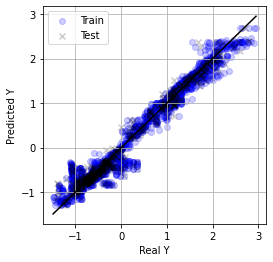

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train_s, y_train_pred, alpha=0.2, c="blue", label='Train')
plt.scatter(y_test_s, y_test_pred, alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train_s.min(), y_train_s.max()], [y_train_s.min(), y_train_s.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['GP'] = [RMSE_train, RMSE_test]
r2_sum['GP'] = [R_square_train, R_square_test]

# **Summary**

In [ ]:
summary = pd.DataFrame(rmse_sum, index=['Train', 'Test'])
summary.style.set_caption("Table of RMSE")

,GP
Train,12.079397
Test,12.177597


In [ ]:
summary = pd.DataFrame(r2_sum, index=['Train', 'Test'])
summary.style.set_caption("Table of R square")

,GP
Train,0.975663
Test,0.974433


# **Feature Importance (should decrease the sample amount)**

Shap of GP

In [ ]:
import shap

explainer = shap.KernelExplainer(gp, X_train)
shap_values = explainer.shap_values(X_test_tensor)
shap.summary_plot(shap_values, X_test_tensor)

Provided model function fails when applied to the provided data set.


AttributeError: ignored

# **Bayesian Optimization**

## Analytic Acquisition Function

In [ ]:
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound

UCB = UpperConfidenceBound(gp, beta=0.1)

bounds = torch.stack([torch.zeros(306), torch.ones(306)])

candidate, acq_value = optimize_acqf(
    UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)

print(candidate)
print(acq_value)

tensor([[0.4192, 0.8521, 0.0983, 0.8956, 0.5999, 0.2856, 0.8689, 0.2783, 0.8791,
         0.5475, 0.2495, 0.7856, 0.4328, 0.9636, 0.5854, 0.4181, 0.3409, 0.5941,
         0.2744, 0.2784, 0.5068, 0.5633, 0.7162, 0.2448, 0.3282, 0.1397, 0.7147,
         0.1446, 0.1045, 0.1120, 0.8531, 0.6050, 0.6780, 0.3037, 0.6440, 0.5063,
         0.5513, 0.1012, 0.2953, 0.3201, 0.3355, 0.9323, 0.1311, 0.2876, 0.4079,
         0.2831, 0.4341, 0.9096, 0.5267, 0.3656, 0.5551, 0.3677, 0.3689, 0.9344,
         0.0565, 0.0296, 0.2842, 0.5698, 0.9409, 0.3970, 0.4340, 0.6697, 0.8316,
         0.1928, 0.6344, 0.9549, 0.0743, 0.8251, 0.9782, 0.5878, 0.7611, 0.7766,
         0.1324, 0.4525, 0.8244, 0.9240, 0.9118, 0.6458, 0.3303, 0.8649, 0.9289,
         0.2437, 0.8391, 0.8064, 0.6438, 0.1798, 0.3175, 0.8539, 0.5624, 0.1682,
         0.7249, 0.6055, 0.0545, 0.0473, 0.9622, 0.1693, 0.0692, 0.5294, 0.2525,
         0.1070, 0.2544, 0.0486, 0.8940, 0.9574, 0.6954, 0.9154, 0.9800, 0.9323,
         0.5569, 0.2666, 0.8

## Monte-Carlo Acquisition Function

In [ ]:
from botorch.optim import optimize_acqf
from botorch.acquisition import qUpperConfidenceBound

qUCB = qUpperConfidenceBound(gp, beta=0.1)

bounds = torch.stack([torch.zeros(310), torch.ones(310)])

candidate, acq_value = optimize_acqf(
    qUCB, bounds=bounds, q=5, num_restarts=5, raw_samples=20, sequential=True
)

print(candidate)
print(acq_value)

tensor([[0.5350, 0.4567, 0.2154,  ..., 0.7444, 0.6585, 0.6162],
        [0.2426, 0.1041, 0.0904,  ..., 0.2900, 0.2782, 0.2742],
        [0.4816, 0.9507, 0.7875,  ..., 0.8367, 0.1469, 0.2812],
        [0.3732, 0.7665, 0.4030,  ..., 0.8335, 0.3265, 0.0354],
        [0.6453, 0.6621, 0.9993,  ..., 0.7832, 0.0707, 0.2988]])
tensor([0.3826, 0.5137, 0.5916, 0.6487, 0.6842], dtype=torch.float64)
